In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from random import randint
from random import random
from math import ceil


import warnings
#warnings.filterwarnings("ignore")

In [3]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_style({'font.family':'serif', 'font.serif':'Computer Modern'})
sns.set_context(font_scale=2, rc={"font.size":10,"axes.titlesize":20,"axes.labelsize":15})

In [4]:
df_train = pd.read_csv("df_train_processed.csv")

In [5]:
df_train = df_train.drop(columns=['actor'])

In [7]:
df_train['vocal_channel'].value_counts()

speech    1080
song       748
Name: vocal_channel, dtype: int64

## Standardization

In [8]:
df_train_num = df_train.select_dtypes(include="number")
df_train_cat = df_train.select_dtypes(include=['object'])

scaler = MinMaxScaler()
df_train_num_scaled = pd.DataFrame(scaler.fit_transform(df_train_num), columns=df_train_num.columns)
df_train = pd.concat([df_train_num_scaled, df_train_cat], axis=1)

In [9]:
df_train_model = df_train

In [10]:
label_encoder = preprocessing.LabelEncoder()
df_train_model['vocal_channel']= label_encoder.fit_transform(df_train_model['vocal_channel'])

In [11]:
df_train_model = pd.get_dummies(df_train_model)

In [12]:
df_vocal_channel_train = df_train_model

## Rendere training dataset imbalanced

In [13]:
def dip_indp_variables(data,target):
    
    X = np.array(data.loc[:, data.columns != target])
    
    y = np.array(data.loc[:, data.columns == target])
    
    result = np.unique(y, return_counts=True)
    
    return  {'X': X,
             'y': y,
             'result': { result[0][0] : result[1][0],
                       result[0][1] : result[1][1]}
           }

In [14]:
dip_indp_variables_train = dip_indp_variables(df_vocal_channel_train,"vocal_channel")

In [15]:
dip_indp_variables_train['result']

{0: 748, 1: 1080}

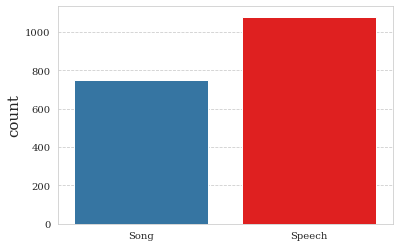

In [139]:
labels = ['Song','Speech']
ax=sns.countplot(x=df_vocal_channel_train['vocal_channel'], palette=['#2478b4','#ff0000'])
ax.set_xticklabels(labels)
ax.set(xlabel=None)
img_name = 'Before_Imbalancing_Vocal_Channel' + '.png'
plt.savefig(img_name,dpi=300, bbox_inches='tight')
plt.show()

In [16]:
def rows_to_remove(data,target,num, dataset):
    
    y = dataset['y']
    
    majority_class = list(dataset['result'].keys())[1]
    
    total_majority_class = dataset['result'][majority_class]
    
    np.random.seed(42)
    
    rows_remove = np.random.choice((data[y == majority_class]).index, total_majority_class-num, replace=False)
    
    df_target = data.drop(index=rows_remove, axis=0)
    
    return {'df_target': df_target,
            'rows_remove': rows_remove}

In [17]:
rows_remove_train = rows_to_remove(df_vocal_channel_train,"vocal_channel", 31, dip_indp_variables_train)

In [18]:
def drop_rows(data, rows_dataset):
    
    df_after_remove = data.drop(index=rows_dataset['rows_remove'], axis=0)
    
    return {'df_after_remove': df_after_remove}

In [19]:
drop_rows_train = drop_rows(df_vocal_channel_train, rows_remove_train)

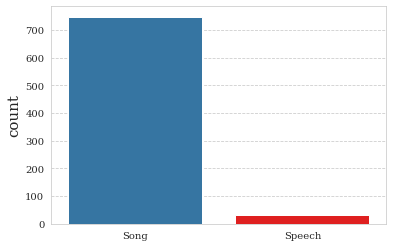

In [140]:
labels = ['Song','Speech']
ax=sns.countplot(x=drop_rows_train['df_after_remove']['vocal_channel'], palette=['#2478b4','#ff0000'])
ax.set_xticklabels(labels)
ax.set(xlabel=None)
img_name = 'After_Imbalancing_Vocal_Channel' + '.png'
plt.savefig(img_name,dpi=300, bbox_inches='tight')
plt.show()

In [20]:
def dip_indip_after_remove(data, target, rows, dip_indp_variables_dataset):
    
    X2 = data.loc[:, data.columns != target]
    
    y2 = np.array([dip_indp_variables_dataset['y'][i] for i in range(len(dip_indp_variables_dataset['y'])) if i not in rows])
    
    result = np.unique(y2, return_counts=True)
    
    return {'X2': X2,
            'y2': y2,
            'result': { result[0][0] : result[1][0],
                      result[0][1] : result[1][1]}
           }

In [21]:
dip_indip_after_remove_train = dip_indip_after_remove(drop_rows_train['df_after_remove'], 
                                                'vocal_channel',
                                                rows_remove_train['rows_remove'], dip_indp_variables_train)

In [22]:
X2 = np.array(dip_indip_after_remove_train['X2'])
y2 = np.array(dip_indip_after_remove_train['y2'].ravel())

In [23]:
np.unique(y2, return_counts=True)

(array([0, 1]), array([748,  31]))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3, random_state=100)

In [25]:
X_train.shape

(545, 390)

In [26]:
from sklearn.manifold import TSNE

In [125]:
def perform_tsne(X_data, y_data,img_name_prefix):
        
        X_reduced = TSNE(random_state=42).fit_transform(X_data)
        
        df = pd.DataFrame({'Dim 1':X_reduced[:,0], 'Dim 2':X_reduced[:,1] ,'label':y_data})
        
        # draw the plot in appropriate place in the grid
        
        sns.lmplot(data=df, x='Dim 1', y='Dim 2', hue='label', legend=False, fit_reg=False, height=8,\
                   palette="Set1")
        plt.legend( loc='upper right', labels=['Song', 'Speech'])
        img_name = img_name_prefix + '.png'
        plt.savefig(img_name,dpi=300, bbox_inches='tight')
        plt.show()
        

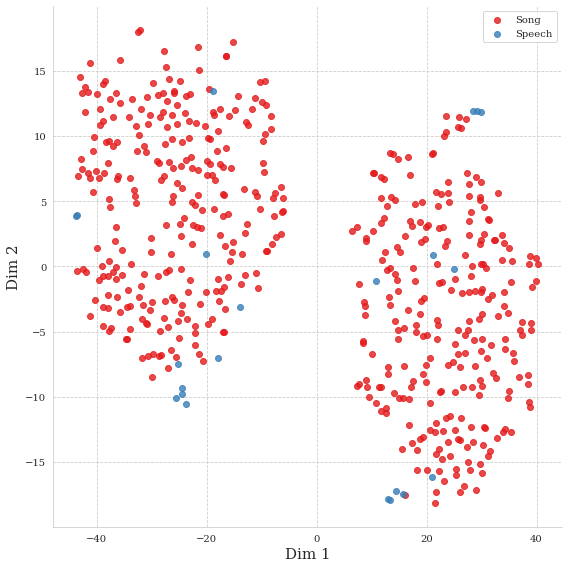

In [126]:
perform_tsne( X_train,y_train, 'Imbalance_Vocal_Channel')

## Decision Tree before Undersampling/Oversampling

In [30]:
from scipy.stats import uniform, randint, loguniform
from sklearn.model_selection import RepeatedStratifiedKFold

In [31]:
def Decision_tree(X_train_array, y_train_array):
    
    param_grid = {
    "min_samples_split": loguniform(1e-2, 1e0),
    "min_samples_leaf": uniform(0.001, 0.2),
    "max_depth": list(range(2,200)),
    "criterion": ["gini", "entropy", "log_loss"],
    
}


    tree = DecisionTreeClassifier(random_state=42)


    tree_cv = RandomizedSearchCV(tree, param_grid, cv=RepeatedStratifiedKFold(n_splits=10,random_state=42),
    n_jobs=-1,
    n_iter=200, error_score='raise')


    tree_cv.fit(X_train_array,y_train_array)

    return tree_cv

In [32]:
decision_tree = Decision_tree(X_train, y_train)

In [33]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 183, 'min_samples_leaf': 0.007130500441161213, 'min_samples_split': 0.032761650805552794}


In [34]:
y_pred_decision_tree = decision_tree.predict(X_test)

In [35]:
def metrics_model( test,predict, majority_class, minority_class):
    new_dic = {}
    new_dic['accuracy'] = accuracy_score(test,predict)
    #new_dic['precision ('+ majority_class + ')'] = precision_score(predict, test, average=None)[0]
    #new_dic['precision ('+ minority_class + ')'] = precision_score(predict, test,average=None)[1]
    #new_dic['recall ('+ majority_class + ')'] = recall_score(predict, test, average=None)[0]
    #new_dic['recall ('+ minority_class + ')'] = recall_score(predict, test, average=None)[1]
    new_dic['f1_score ('+ majority_class + ')'] = f1_score(test,predict, average=None)[0]
    new_dic['f1_score ('+ minority_class + ')'] = f1_score(test,predict, average=None)[1]
    
    return new_dic

In [36]:
data_decision_tree = metrics_model(y_test, y_pred_decision_tree, 'song', 'speech')
data_decision_tree

{'accuracy': 0.9743589743589743,
 'f1_score (song)': 0.9866071428571429,
 'f1_score (speech)': 0.7000000000000001}

In [37]:
print(classification_report(y_pred_decision_tree,y_test))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       223
           1       0.78      0.64      0.70        11

    accuracy                           0.97       234
   macro avg       0.88      0.81      0.84       234
weighted avg       0.97      0.97      0.97       234



## KNN before Undersampling/Oversampling

In [38]:
def spearman_selector(target, df, k):
    """Returns a df comprising all the features highly correlated (above k and below -k)
    with the binary target according Spearman coefficient. Target must be a pd Series"""
    df = df.select_dtypes(include="number")
    target = target.map({target.unique()[0]:0, target.unique()[1]:1})
    new_df = pd.DataFrame()
    for col in df:
        spearman = stats.spearmanr(df[col], target)[0]
        if spearman > k or spearman < -k:
            new_df[col] = df[col]
    return new_df

In [39]:
df_vocal_channel_train_knn = spearman_selector(df_train['vocal_channel'], df_train, 0.7)

In [40]:
df_train_cat_knn = df_train.select_dtypes(include=['object'])
df_vocal_channel_train = pd.concat([df_vocal_channel_train_knn, df_train_cat_knn], axis=1)

In [41]:
df_vocal_channel_train = pd.get_dummies(df_vocal_channel_train)

In [42]:
dip_indp_variables_knn = dip_indp_variables(df_vocal_channel_train,"vocal_channel")

In [43]:
dip_indp_variables_knn['result']

{0: 748, 1: 1080}

In [44]:
dip_indp_variables_knn['X'].shape

(1828, 36)

In [45]:
rows_remove_knn = rows_to_remove(df_vocal_channel_train,"vocal_channel", 31, dip_indp_variables_knn)

In [46]:
drop_rows_knn = drop_rows(df_vocal_channel_train, rows_remove_knn)

In [47]:
dip_indip_after_remove_knn = dip_indip_after_remove(drop_rows_knn['df_after_remove'], 
                                                'vocal_channel',
                                                rows_remove_knn['rows_remove'], dip_indp_variables_knn)

In [48]:
X2_knn = np.array(dip_indip_after_remove_knn['X2'])
y2_knn = np.array(dip_indip_after_remove_knn['y2'].ravel())

In [49]:
np.unique(y2_knn, return_counts=True)

(array([0, 1]), array([748,  31]))

In [50]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X2_knn, y2_knn, test_size=0.3, random_state=100)

In [51]:
X_train_knn.shape

(545, 36)

In [52]:
def Knn(X_train_array, y_train_array):   
    
    knn = KNeighborsClassifier()
    
    parameters = {
        'n_neighbors': np.arange(2, X_train_array.shape[0]//2),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'cityblock', 'minkowski']
        }
    
    knn_cv = RandomizedSearchCV(knn,
                     parameters,
                    cv=RepeatedStratifiedKFold(n_splits= 10,random_state=42),
                    n_jobs=-1,
                    refit=True,)
    
    knn_cv.fit(X_train_array, y_train_array)
    
    return knn_cv

In [53]:
knn = Knn(X_train_knn, y_train_knn)

In [54]:
print(knn.best_params_)

{'weights': 'distance', 'n_neighbors': 153, 'metric': 'cityblock'}


In [55]:
y_pred_knn = knn.predict(X_test_knn)

In [56]:
data_knn= metrics_model( y_test_knn, y_pred_knn,'song', 'speech')
data_knn

{'accuracy': 0.9615384615384616,
 'f1_score (song)': 0.9803921568627451,
 'f1_score (speech)': 0.0}

In [57]:
print(classification_report(y_test_knn,y_pred_knn))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       225
           1       0.00      0.00      0.00         9

    accuracy                           0.96       234
   macro avg       0.48      0.50      0.49       234
weighted avg       0.92      0.96      0.94       234



/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [58]:
def combined_results(data,data1):
    combined_dic = {'Decision_tree': data, 'Knn': data1}
    
    return combined_dic

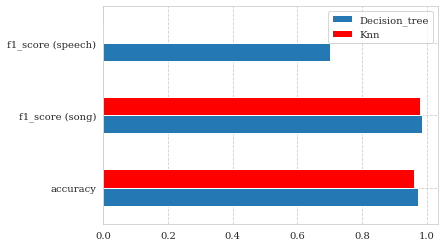

In [127]:
combined_dic = combined_results(data_decision_tree,data_knn)
df = pd.DataFrame(combined_dic)
df.plot(kind='barh', color=['#2478b4','red'])
plt.savefig('Imbalanced_Vocal_Channel_Result',dpi=300, bbox_inches='tight')
plt.show()

## Undersampling

In [60]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import EditedNearestNeighbours

## Random Undersampling

In [61]:
def randomUnderSampler(X_train_array, y_train_array):
    
    
    rus = RandomUnderSampler(random_state=42)
    
    X_res_rus, y_res_rus = rus.fit_resample(X_train_array, y_train_array)
    
    return X_res_rus, y_res_rus

In [62]:
X_res_rus, y_res_rus = randomUnderSampler(X_train, y_train)

In [63]:
X_res_rus_knn, y_res_rus_knn = randomUnderSampler(X_train_knn, y_train_knn)

In [64]:
print('Resampled dataset shape %s' % Counter(y_res_rus))

Resampled dataset shape Counter({0: 22, 1: 22})


In [65]:
len(X_res_rus)

44

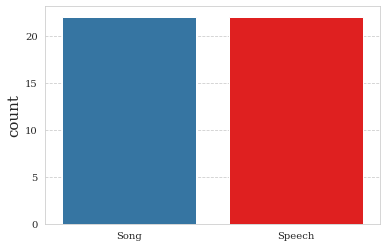

In [72]:
labels = ['Song','Speech']
ax=sns.countplot(x=y_res_rus, palette=['#2478b4','#ff0000'])
ax.set_xticklabels(labels)
img_name = 'RandomUndersampling_Vocal_Channel' + '.png'
plt.savefig(img_name,dpi=300, bbox_inches='tight')
plt.show()

## KNN dopo RandomUndersampling

In [73]:
knn_under_rus = Knn(X_res_rus_knn, y_res_rus_knn)

In [74]:
print(knn_under_rus.best_params_)

{'weights': 'uniform', 'n_neighbors': 11, 'metric': 'cityblock'}


In [75]:
y_pred_knn_under_rus = knn_under_rus.predict(X_test_knn)

In [76]:
knn_rus = metrics_model(y_test_knn, y_pred_knn_under_rus, 'song', 'speech')
knn_rus

{'accuracy': 0.8974358974358975,
 'f1_score (song)': 0.9439252336448599,
 'f1_score (speech)': 0.39999999999999997}

In [77]:
print(classification_report(y_test_knn, y_pred_knn_under_rus))

              precision    recall  f1-score   support

           0       1.00      0.90      0.94       225
           1       0.26      0.89      0.40         9

    accuracy                           0.90       234
   macro avg       0.63      0.89      0.67       234
weighted avg       0.97      0.90      0.92       234



## Decision Tree dopo RandomUndersampling

In [78]:
decision_tree_under_rus = Decision_tree(X_res_rus, y_res_rus)

In [79]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree_under_rus.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 73, 'min_samples_leaf': 0.02182171639691477, 'min_samples_split': 0.39795335528782644}


In [80]:
y_pred_decision_tree_under_rus = decision_tree_under_rus.predict(X_test)

In [81]:
print(classification_report(y_test, y_pred_decision_tree_under_rus))

              precision    recall  f1-score   support

           0       0.99      0.77      0.87       225
           1       0.13      0.89      0.23         9

    accuracy                           0.77       234
   macro avg       0.56      0.83      0.55       234
weighted avg       0.96      0.77      0.84       234



In [82]:
decision_tree_rus = metrics_model( y_test, y_pred_decision_tree_under_rus, 'song', 'speech')
decision_tree_rus

{'accuracy': 0.7735042735042735,
 'f1_score (song)': 0.8671679197994986,
 'f1_score (speech)': 0.2318840579710145}

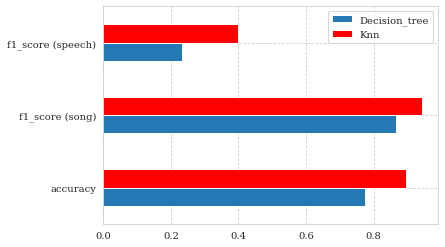

In [83]:
combined_dic_rus = combined_results(decision_tree_rus,knn_rus)
df = pd.DataFrame(combined_dic_rus)
df.plot(kind='barh', color=['#2478b4','red'])
plt.savefig('RandomUndersampling_Vocal_Channel_Result',dpi=300, bbox_inches='tight')
plt.show()

## EditedNearestNeighbors

In [84]:
def enn(X_train_array, y_train_array):
    
    enn = EditedNearestNeighbours()
    
    X_res_enn, y_res_enn = enn.fit_resample(X_train_array, y_train_array)
    
    return X_res_enn, y_res_enn

In [85]:
X_res_enn, y_res_enn = enn(X_train, y_train)

In [86]:
X_res_enn_knn, y_res_enn_knn = enn(X_train_knn, y_train_knn)

In [87]:
print('Resampled dataset shape %s' % Counter(y_res_enn))

Resampled dataset shape Counter({0: 517, 1: 22})


In [88]:
print('Resampled dataset shape %s' % Counter(y_res_enn_knn))

Resampled dataset shape Counter({0: 509, 1: 22})


In [89]:
len(X_res_enn)

539

In [90]:
len(X_res_enn_knn)

531

## KNN after EditedNearestNeighbors

In [91]:
knn_under_enn = Knn(X_res_enn_knn, y_res_enn_knn)

In [92]:
print(knn_under_enn.best_params_)

{'weights': 'distance', 'n_neighbors': 242, 'metric': 'cityblock'}


In [93]:
y_pred_knn_under_enn = knn_under_enn.predict(X_test_knn)

In [94]:
knn_enn = metrics_model(y_test_knn, y_pred_knn_under_enn, 'song', 'speech')
knn_enn

{'accuracy': 0.9615384615384616,
 'f1_score (song)': 0.9803921568627451,
 'f1_score (speech)': 0.0}

In [95]:
print(classification_report( y_pred_knn_under_enn, y_test_knn))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       234
           1       0.00      0.00      0.00         0

    accuracy                           0.96       234
   macro avg       0.50      0.48      0.49       234
weighted avg       1.00      0.96      0.98       234



/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Decision Tree after EditedNearestNeighbors

In [96]:
decision_tree_under_enn = Decision_tree(X_res_enn, y_res_enn)

In [97]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree_under_enn.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 0.009334580120476853, 'min_samples_split': 0.014776923741663395}


In [98]:
y_pred_decision_tree_under_enn = decision_tree_under_enn.predict(X_test)

In [99]:
decision_tree_enn = metrics_model(y_test,y_pred_decision_tree_under_enn, 'song', 'speech')

In [100]:
print(classification_report(y_test, y_pred_decision_tree_under_enn))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       225
           1       0.64      0.78      0.70         9

    accuracy                           0.97       234
   macro avg       0.81      0.88      0.84       234
weighted avg       0.98      0.97      0.98       234



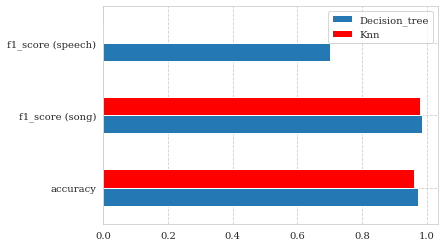

In [101]:
combined_dic_enn = combined_results(decision_tree_enn,knn_enn)
df = pd.DataFrame(combined_dic_enn)
df.plot(kind='barh', color=['#2478b4','red'])
#plt.savefig('dddd',dpi=300, bbox_inches='tight')
plt.show()

## Oversampling

In [102]:
from imblearn.over_sampling import SMOTE

## SMOTE

In [103]:
def smote(X_train_array, y_train_array):
    
    sm = SMOTE(random_state=42)
    
    X_res_sm, y_res_sm = sm.fit_resample(X_train_array, y_train_array)
    
    return X_res_sm, y_res_sm

In [104]:
X_res_sm, y_res_sm = smote(X_train, y_train)

In [105]:
X_res_sm_knn, y_res_sm_knn = smote(X_train_knn, y_train_knn)

In [106]:
print('Resampled dataset shape %s' % Counter(y_res_sm))

Resampled dataset shape Counter({0: 523, 1: 523})


In [107]:
len(X_train)

545

In [108]:
len(X_train_knn)

545

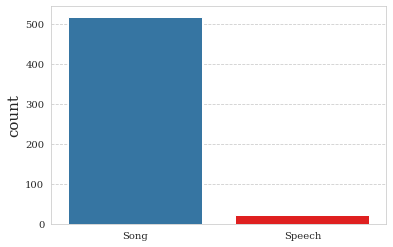

In [109]:
labels = ['Song','Speech']
ax=sns.countplot(x=y_res_enn, palette=['#2478b4','#ff0000'])
ax.set_xticklabels(labels)
img_name = 'SMOTE_vocal_channel' + '.png'
plt.savefig(img_name,dpi=300, bbox_inches='tight')
plt.show()

## KNN after SMOTE

In [110]:
knn_over_sm = Knn(X_res_sm_knn, y_res_sm_knn)

In [111]:
print(knn_over_sm.best_params_)

{'weights': 'uniform', 'n_neighbors': 433, 'metric': 'cityblock'}


In [112]:
y_pred_knn_over_sm = knn_over_sm.predict(X_test_knn)

In [123]:
knn_smote = metrics_model( y_test_knn, y_pred_knn_over_sm, 'song', 'speech')
knn_smote

{'accuracy': 0.9273504273504274,
 'f1_score (song)': 0.9607390300230947,
 'f1_score (speech)': 0.5142857142857142}

In [114]:
print(classification_report(y_test_knn, y_pred_knn_over_sm))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96       225
           1       0.35      1.00      0.51         9

    accuracy                           0.93       234
   macro avg       0.67      0.96      0.74       234
weighted avg       0.97      0.93      0.94       234



## Decision Tree after SMOTE

In [115]:
decision_tree_over_sm = Decision_tree(X_res_sm, y_res_sm)

In [116]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree_over_sm.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 119, 'min_samples_leaf': 0.00360591355141675, 'min_samples_split': 0.010675300252415651}


In [117]:
y_pred_decision_tree_over_sm = decision_tree_over_sm.predict(X_test)

In [118]:
decision_tree_smote = metrics_model(y_test, y_pred_decision_tree_over_sm, 'song', 'speech')

In [119]:
print(classification_report(y_test, y_pred_decision_tree_over_sm))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       225
           1       0.44      0.44      0.44         9

    accuracy                           0.96       234
   macro avg       0.71      0.71      0.71       234
weighted avg       0.96      0.96      0.96       234



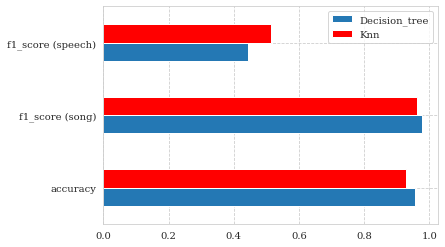

In [124]:
combined_dic_smote = combined_results(decision_tree_smote,knn_smote)
df = pd.DataFrame(combined_dic_smote)
df.plot(kind='barh', color=['#2478b4','red'])
plt.savefig('SMOTE_Vocal_Channel_Result',dpi=300, bbox_inches='tight')
plt.show()